# Masking and second order DPA

You need:
* `plaintext.txt`: all PT blocks, (one block per line, in hex, bytes separated by spaces)
* `ciphertext.txt`: all CT blocks, (one block per line, in hex, bytes separated by spaces)
* `traceLength.txt`: how many samples per trace (one decimal number)
* `traces.bin`: raw measured traces, one byte per sample (uint8), all traces together continuously
Original: https://colab.research.google.com/gist/bucekj/8c913671f00d4ee2ac59649cbd6b9b7b#scrollTo=8fW8nPQ5uyEO 

### 1. Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import sys
from Crypto.Cipher import AES
%matplotlib widget

# AES SBOX
sbox = np.array([
    0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
    0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
    0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
    0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
    0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
    0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
    0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
    0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
    0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
    0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
    0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
    0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
    0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
    0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
    0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
    0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
    ], dtype='uint8')

# Hamming weight lookup table
hw_table = []
for i in range(256):
    s = '{0:08b}'.format(i)
    hw_table.append(s.count('1'))
hw_table = np.array(hw_table, 'uint8')

# Correlation of two matrices
def correlate(x, y):
    """
    Correlate all columns from matrix x of shape (a,b)
    with all columns from matrix y of shape (a,c),
    creating correlation matrix C of shape (b,c).
    
    Originally matlab script by Jiri Bucek in NI-HWB.
    """
    x = x - np.average(x, 0) # remove vertical averages
    y = y - np.average(y, 0) # remove vertical averages
    C = x.T @ y              # (n-1) Cov(x,y)
    C = C / (np.sum(x**2, 0)**(1/2))[:,np.newaxis] # divide by (n-1) Var(x)
    C = C / (np.sum(y**2, 0)**(1/2))               # divide by (n-1) Var(y)
    return C

# Load PT of CT from file
def load_text(file_name):
    """
    Load any text PT/CT from file containing hex strings with bytes 
    separated by spaces, one block per line
    Output is a matrix of bytes (np.array)
    """
    txt_str = open(file_name).readlines()
    del txt_str[-1] #discard last empty line
    #split each line into bytes and convert from hex
    txt_bytes_list = list(
        map(lambda line: 
                list(
                    map(lambda s: int(s, 16),
                        line.rstrip().split(" "))
                ),
            txt_str)
        )
    return np.array(txt_bytes_list, 'uint8')


def load(folder_name, start = None, end = None):
    # read plaintext inputs
    inputs = load_text(folder_name + "/plaintext.txt")

    # read length of one complete trace (number of samples per trace)
    with open(folder_name + "/traceLength.txt", "r") as fin:
        trace_length = int(fin.readline())

    if end == None and start == None:
        start = 0
        end = trace_length

    # read traces from binary file
    traces = np.fromfile(folder_name + "/traces.bin", dtype='uint8') # read as linear array
    traces = np.reshape(traces, (traces.size // trace_length, trace_length)) # reshape into matrix
    traces = traces[:, start:end] # select only the interesting part of each trace
    traces = traces.astype('float32')

    # load output
    ciphertext = load_text(folder_name + "/ciphertext.txt")
    ciphertextBlock = bytes(ciphertext[0])

    # extract plain text
    plaintextBlock = bytes(inputs[0])
    
    return inputs, traces, ciphertextBlock, plaintextBlock

def test_key(kk, ciphertext_block, plaintext_block):
    key_bytes = bytes(kk)
    cipher = AES.new(key_bytes, AES.MODE_ECB)

    # Encrypting the plaintext using the cipher object
    encrypted_plaintext = cipher.encrypt(plaintext_block)

    # Verifing that the encrypted plaintext matches the given ciphertext
    if encrypted_plaintext == ciphertext_block:
        print("The key is valid !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    else:
        print("Invalid key :(")

def break_all_bytes(traces, inputs, ciphertext_block, plaintext_block):
    kk = np.zeros(16, dtype='uint8')
    keys = np.array(range(0, 256))
    for i in range(0, 16):
        inp = inputs[:, i]
        # XOR each data byte with each key
        xmat = inp[:, np.newaxis] ^ keys
        # Substitute with SBOX all XORed values -- matrix of intermediate values
        smat = sbox[xmat]
        # Compute Hamming Weights -- the matrix of hypothetical power consumption
        hmat = hw_table[smat]
        # Find correlation between hamming weights and traces
        corr = correlate(hmat, traces)
        # Display first key byte correlation trace
        acorr = abs(corr)
        # Find the most correlated key and store it in the corr_table
        max_acorr = acorr.max()
        (k, j) = np.where(acorr == max_acorr) # find indices of maximum
        kk[i] = k
    print("Key: " + "".join([str(k) + " " for k in kk]))
    test_key(kk, ciphertext_block, plaintext_block)

### 2. Normal DPA attack

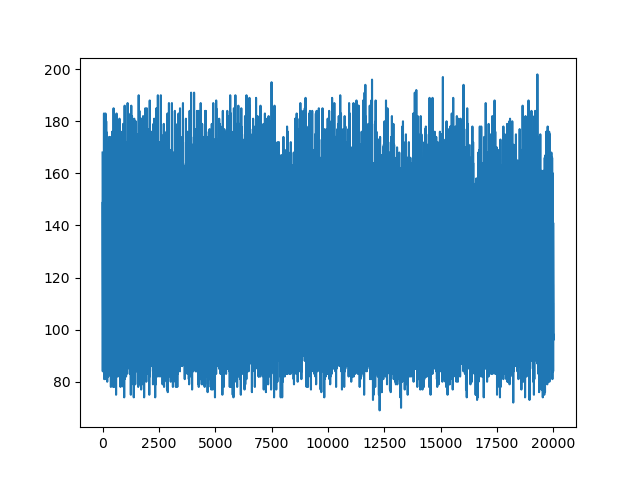

(1000, 20000)

In [10]:
inputs, traces, ciphertext_block, plaintext_block = load("measurement", 704400, 704400+20000)

fig = plt.figure()
plt.plot(traces[0].T)
plt.show()
traces.shape

- Discover the secret key (with hamming wieght power model)

In [ ]:
break_all_bytes(traces, inputs, ciphertext_block, plaintext_block)

### 3. Attacking masking
Find the first round by correlation with the plaintext. You should see a series of peaks right after the trigger, and then again after a few milliseconds. This is where the first round starts.

In [ ]:
hmat = hw_table[inputs]
for i in range(20,24):
    print(f"{30000*i} - {30000+i*30000}")
    corr = correlate(hmat, traces[:,30000*i:30000+i*30000])
    fig = plt.figure()
    plt.plot(corr.T)
    plt.show()

With cross-correlation, we found plaintext processing of the traces (697410:704400). We now that the mask computation should be right after, thus we select the 30k traces after the last "peak".

In [3]:
# traces = traces[:,704400:704400+30000]
# traces.shape

(1000, 30000)

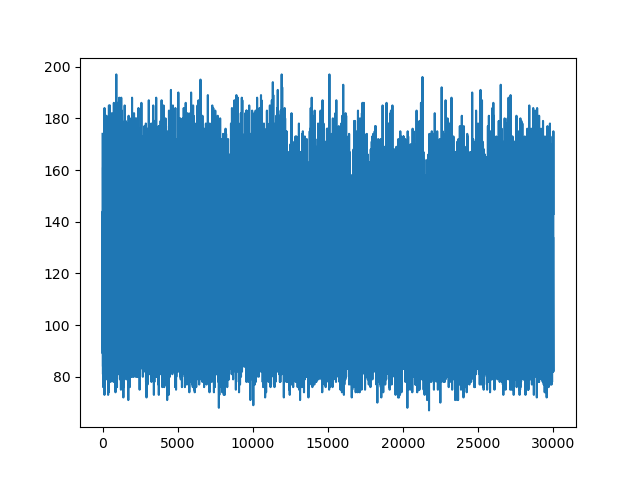

In [5]:
fig = plt.figure()
plt.plot(traces[1].T)
# plt.plot(traces[1].T)
# plt.plot(traces[2].T)
plt.show()


In [2]:
inputs, traces, ciphertext_block, plaintext_block = load("measurement", 704400, 704400+20000)

In [13]:
def compress_trace(traces, factor):
    return signal.resample(traces, int(traces.shape[1] / factor), axis=1)

def align_traces(traces, pattern):
    aligned_traces = np.zeros_like(traces)
    shifts = []
    for i, trace in enumerate(traces):
        corr = signal.correlate(trace, pattern, mode="full")
        shift = signal.correlation_lags(trace.size, pattern.size)[np.argmax(corr)]
        sys.stdout.write(f"\r{i}:{shift.item()}")
        shifts.append(shift)
        aligned_traces[i] = np.roll(trace, trace.size - shift)
    mean = 0
    for s in shifts:
        mean += s
    mean /= len(shifts)
    sys.stdout.write(f"\rmean shift = {mean}\n")
    return aligned_traces

def abs_preprocess(traces):
    d = 50
    l = traces.shape[1]
    T_tilda = np.zeros([traces.shape[0],(l-d)*d], dtype=np.float32)
    for i in range(l-d):
        # absolute_diff = np.abs(traces[:,i:i+1] - traces[:,i+1:i+1+d])
        absolute_diff = np.abs(traces[:,i:i+1] - traces[:,i+1:i+1+d])
        T_tilda[:,i*d:i*d+d] = absolute_diff
    return T_tilda

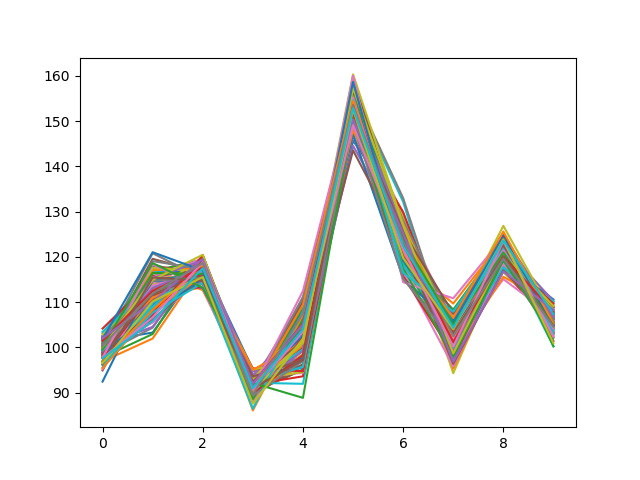

(1000, 4000)


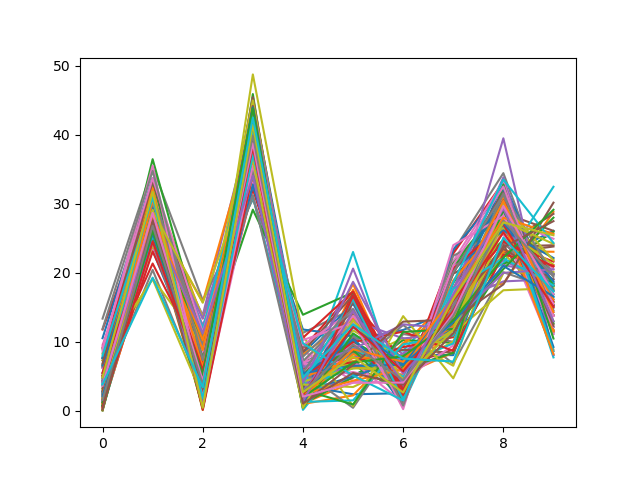

(1000, 197500)


In [14]:
start = 500

_traces = traces.copy()

_traces = compress_trace(_traces, 5)
fig = plt.figure()
plt.plot(_traces[800:900, start:start+10].T)
plt.show()
print(_traces.shape)

_traces = abs_preprocess(_traces)
fig = plt.figure()
plt.plot(_traces[800:900, start:start+10].T)
plt.show()
print(_traces.shape)

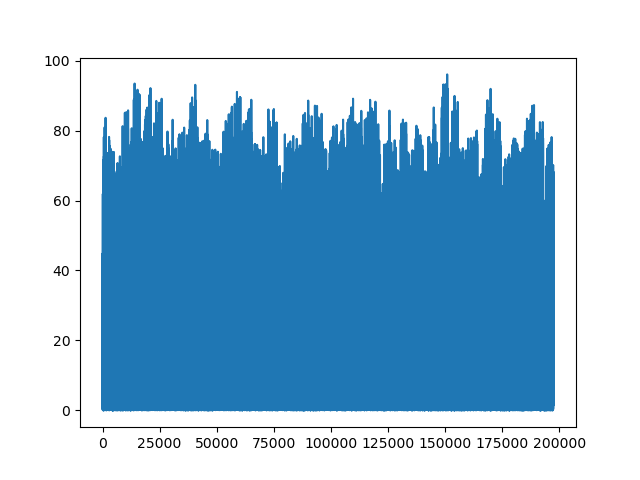

(1000, 197500)


In [5]:
start = 12000
fig = plt.figure()
# plt.plot(_traces[800:900, start:start+10].T)
plt.plot(_traces[0].T)
plt.show()
print(_traces.shape)

In [15]:
for j in range(7):
    s = 25000
    r = (s*j,s*j+s)
    print(f"range={r}")
    break_all_bytes(_traces[:999,r[0]:r[1]], inputs, ciphertext_block, plaintext_block)

range=(0, 25000)
Key: 45 243 34 108 55 118 41 171 113 248 22 27 9 197 155 47 
Invalid key :(
range=(25000, 50000)
Key: 247 230 178 54 186 112 41 111 125 162 130 144 191 197 27 188 
Invalid key :(
range=(50000, 75000)
Key: 21 141 101 241 122 141 7 247 125 137 5 143 3 120 133 119 
Invalid key :(
range=(75000, 100000)
Key: 64 187 223 249 142 12 41 247 205 248 91 174 88 78 175 254 
Invalid key :(
range=(100000, 125000)
Key: 87 161 162 19 182 43 41 126 112 223 16 12 202 217 76 2 
Invalid key :(
range=(125000, 150000)
Key: 241 53 57 163 46 41 41 247 124 248 10 16 61 169 185 195 
Invalid key :(
range=(150000, 175000)
Key: 45 226 149 228 36 178 41 126 125 248 34 165 167 147 49 122 
Invalid key :(


Check the alignment of the interesting part of the traces – realign by cross-correlation.

Compress the traces to reduce the amount of measured data.

In [4]:
# traces = traces.reshape([1000,3750,8]).mean(axis=2, dtype=np.float32)

> As we can see it's already aligned, no need for realignment <br>

Combine trace samples

(1000, 185000)

Check the alignment of the interesting part of the traces – realign by cross-correlation.

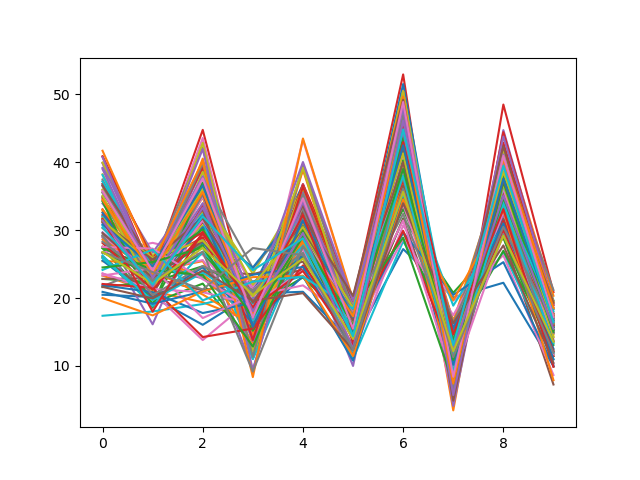

In [9]:
fig = plt.figure()
plt.plot(T_tilda[800:900, start:start+10].T)
plt.show()

In [18]:
break_all_bytes(T_tilda[:999], inputs, ciphertext_block, plaintext_block)